# Facies classification using Machine Learning

<hr />

## Contest entry by Bryan Page

#### This version has been validated by Matt

<hr />

### Based on [the original notebook](../Facies_classification.ipynb) by Brendon Hall, [Enthought](https://www.enthought.com/)

<hr />

### Matt's current sklearn version

In [1]:
import sklearn

print(sklearn.__version__)

0.18


<hr />

## Exploring the dataset

First, we will examine the data set we will use to train the classifier.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = '../facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


Remove a single well to use as a blind test later.

In [3]:
blind = training_data[training_data['Well Name'] == 'SHANKLE']
training_data = training_data[training_data['Well Name'] != 'SHANKLE']

In [4]:
'SHANKLE' in training_data['Well Name'].unique()

False

In [5]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (9, object): [SHRIMPLIN, ALEXANDER D, LUKE G U, KIMZEY A, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

These are the names of the 10 training wells in the Council Grove reservoir.  Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone. 

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial.  We also create the abbreviated facies labels, and add those to the `facies_vectors` dataframe.

In [6]:
# 1=sandstone  2=c_siltstone   3=f_siltstone # 4=marine_silt_shale 
#5=mudstone 6=wackestone 7=dolomite 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3700.000000,3700.000000,3700.000000,3700.000000,3700.000000,3700.000000,2783.000000,3700.000000,3700.000000
mean,4.615676,2908.853378,64.873649,0.663053,4.651677,12.892826,3.805693,1.540000,0.524125
std,2.475808,139.010855,30.817166,0.253863,5.109006,6.796219,0.894118,0.498465,0.287147
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2818.500000,43.778250,0.502000,1.800000,8.350000,NaN,1.000000,0.278000
50%,4.000000,2939.000000,64.817000,0.645613,4.400000,11.857500,NaN,2.000000,0.531000
75%,7.000000,3015.125000,80.322500,0.823000,7.600000,15.750000,NaN,2.000000,0.772000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


This is a quick view of the statistical distribution of the input variables.  Looking at the `count` values, most values have 4149 valid values except for `PE`, which has 3232.  In this tutorial we will drop the feature vectors that don't have a valid `PE` entry.

In [7]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]

In [8]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000
mean,4.558390,2873.456522,66.249445,0.644637,3.754963,13.118929,3.805693,1.523895,0.523057
std,2.515249,138.349383,31.610849,0.241922,5.045916,7.389665,0.894118,0.499518,0.287499
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2767.500000,46.081500,0.497000,1.300000,8.165000,3.200000,1.000000,0.276500
50%,4.000000,2895.000000,65.541000,0.627000,3.581000,11.900000,3.600000,2.000000,0.529000
75%,7.000000,2987.000000,80.714000,0.812323,6.500000,16.144000,4.400000,2.000000,0.771500
max,9.000000,3122.500000,361.150000,1.480000,18.500000,84.400000,8.094000,2.000000,1.000000


Let's take a look at the data from individual wells in a more familiar log plot form.  We will create plots for the five well log variables, as well as a log for facies labels.  The plots are based on the those described in Alessandro Amato del Monte's [excellent tutorial](https://github.com/seg/tutorials/tree/master/1504_Seismic_petrophysics_1).

In [9]:
#I changed the colors to match the paper for easier compare.
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histgram of the number of training examples for each facies class.

SS      170
CSiS    649
FSiS    498
SiSh    177
MS      198
WS      391
D        81
PS      458
BS      161
Name: Facies, dtype: int64

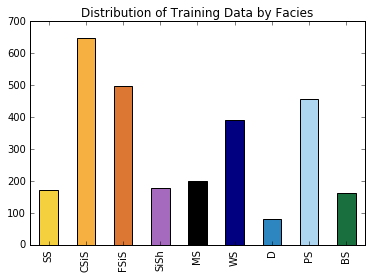

In [10]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

## Conditioning the data set

Now we extract just the feature variables we need to perform the classification.  The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

In [11]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000
mean,66.249445,0.644637,3.754963,13.118929,3.805693,1.523895,0.523057
std,31.610849,0.241922,5.045916,7.389665,0.894118,0.499518,0.287499
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.081500,0.497000,1.300000,8.165000,3.200000,1.000000,0.276500
50%,65.541000,0.627000,3.581000,11.900000,3.600000,2.000000,0.529000
75%,80.714000,0.812323,6.500000,16.144000,4.400000,2.000000,0.771500
max,361.150000,1.480000,18.500000,84.400000,8.094000,2.000000,1.000000


In [12]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [13]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.3, random_state=42)

/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Training the SVM classifier

Now we use the cleaned and conditioned training set to create a facies classifier.  As mentioned above, we will use a type of machine learning model known as a [support vector machine](https://en.wikipedia.org/wiki/Support_vector_machine).  The SVM is a map of the feature vectors as points in a multi dimensional space, mapped so that examples from different facies are divided by a clear gap that is as wide as possible.

### [Matt: I changed this to the LinearSVC as well; I am also setting a random state to ensure it shuffles the same every time.]

In [14]:
from sklearn import svm

clf = svm.LinearSVC(random_state=42) 

Now we can train the classifier using the training set we created above.

In [15]:
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [16]:
predicted_labels = clf.predict(X_test)

In [17]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    29    25     1                                        55
     CSiS     3   160    33                             1         197
     FSiS          48    79     1                       1     2   131
     SiSh                 1    32          16           4     1    54
       MS           3     1     8          45     2    14     2    75
       WS                      12          65     1    29     2   109
        D                       4                 3    19          26
       PS           1     1     5          42          76    13   138
       BS                       1           2          17    30    50

Precision  0.91  0.68  0.68  0.51  0.00  0.38  0.50  0.47  0.60  0.54
   Recall  0.53  0.81  0.60  0.59  0.00  0.60  0.12  0.55  0.60  0.57
       F1  0.67  0.74  0.64  0.55  0.00  0.47  0.19  0.51  0.60  0.54


In [18]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [19]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [20]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.567665
Adjacent facies classification accuracy = 0.906587


## Model parameter selection

The classifier so far has been built with the default parameters.  However, we may be able to get improved classification results with optimal parameter choices.

In [21]:
#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = False

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = int(plot_number / 2)
        column = int(plot_number % 2)
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C=c_value, gamma=gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)

        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)

The best accuracy on the cross validation error curve was achieved for `gamma = 1`, and `C = 10`.  We can now create and train an optimized classifier based on these parameters:

In [22]:
clf = svm.LinearSVC(class_weight='balanced', tol=1e-03, random_state=42)        
clf.fit(X_train, y_train)

cv_conf = confusion_matrix(y_test, clf.predict(X_test))

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.51
Optimized adjacent facies classification accuracy = 0.88


In [23]:
display_cm(cv_conf, facies_labels, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    40    14     1                                        55
     CSiS    35   113    48                                   1   197
     FSiS     6    39    80     1                 1     2     2   131
     SiSh                 1    33           6    11     2     1    54
       MS     1     2     1    11     5    40     6     5     4    75
       WS                      13     2    58    10    11    15   109
        D                       2                19     3     2    26
       PS           1     1     5     3    41    14    37    36   138
       BS                       1           3           7    39    50

Precision  0.49  0.67  0.61  0.50  0.50  0.39  0.31  0.55  0.39  0.54
   Recall  0.73  0.57  0.61  0.61  0.07  0.53  0.73  0.27  0.78  0.51
       F1  0.58  0.62  0.61  0.55  0.12  0.45  0.44  0.36  0.52  0.49


In [24]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    54           1                                        55
     CSiS         196                                         1   197
     FSiS     6         119     1                 1     2     2   131
     SiSh                 1    33           6    11     2     1    54
       MS     1     2     1          56           6     5     4    75
       WS                      13          81                15   109
        D                       2                22           2    26
       PS           1     1     5     3               128         138
       BS                       1           3                46    50

Precision  0.89  0.98  0.97  0.60  0.95  0.90  0.55  0.93  0.65  0.89
   Recall  0.98  0.99  0.91  0.61  0.75  0.74  0.85  0.93  0.92  0.88
       F1  0.93  0.99  0.94  0.61  0.84  0.81  0.67  0.93  0.76  0.88


## Applying the classification model to the blind data

We held a well back from the training, and stored it in a dataframe called `blind`:

In [25]:
blind

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
937,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000
938,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984
939,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968
940,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952
941,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935
...,...,...,...,...,...,...,...,...,...,...,...
1381,8,C LM,SHANKLE,3006.0,32.84,1.120,-2.2,3.455,5.1,2,0.060
1382,8,C LM,SHANKLE,3006.5,25.16,1.112,-1.6,2.890,4.8,2,0.045
1383,8,C LM,SHANKLE,3007.0,25.16,1.112,-1.6,2.890,4.8,2,0.030
1384,4,C LM,SHANKLE,3007.5,26.22,1.092,-0.4,3.400,4.5,2,0.030


The label vector is just the `Facies` column:

In [26]:
y_blind = blind['Facies'].values

We can form the feature matrix by dropping some of the columns and making a new dataframe:

In [27]:
well_features = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)

Now we can transform this with the scaler we made before:

In [28]:
X_blind = scaler.transform(well_features)

Now it's a simple matter of making a prediction and storing it back in the dataframe:

In [29]:
y_pred = clf.predict(X_blind)
blind['Prediction'] = y_pred

Let's see how we did with the confusion matrix:

In [30]:
cv_conf = confusion_matrix(y_blind, y_pred)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.55
Optimized adjacent facies classification accuracy = 0.93


We managed 0.75 using the test data, but it was from the same wells as the training data. This more reasonable test does not perform as well...

In [31]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    75    14                                              89
     CSiS    28    43    16     2                                  89
     FSiS     4    61    52                                       117
     SiSh                       5           2                       7
       MS                      12     2     2     2     1          19
       WS                      14     1    45     3     7     1    71
        D                                        17                17
       PS                       1     5    17           9     8    40
       BS                                                           0

Precision  0.70  0.36  0.76  0.15  0.25  0.68  0.77  0.53  0.00  0.61
   Recall  0.84  0.48  0.44  0.71  0.11  0.63  1.00  0.23  0.00  0.55
       F1  0.77  0.42  0.56  0.24  0.15  0.66  0.87  0.32  0.00  0.56


...but does remarkably well on the adjacent facies predictions. 

In [32]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    89                                                    89
     CSiS          87           2                                  89
     FSiS     4         113                                       117
     SiSh                       5           2                       7
       MS                            16           2     1          19
       WS                      14          56                 1    71
        D                                        17                17
       PS                       1     5                34          40
       BS                                                           0

Precision  0.96  1.00  1.00  0.23  0.76  0.97  0.89  0.97  0.00  0.96
   Recall  1.00  0.98  0.97  0.71  0.84  0.79  1.00  0.85  0.00  0.93
       F1  0.98  0.99  0.98  0.34  0.80  0.87  0.94  0.91  0.00  0.94


In [33]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

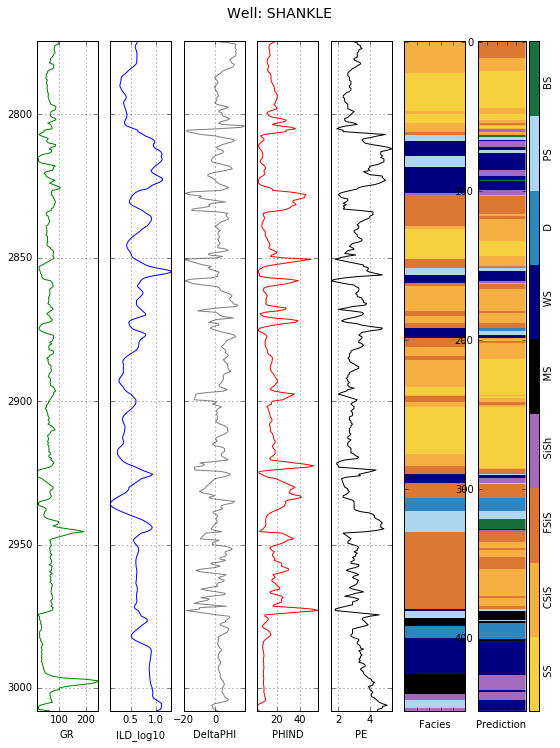

In [34]:
compare_facies_plot(blind, 'Prediction', facies_colors)

## Applying the classification model to new data

Now that we have a trained facies classification model we can use it to identify facies in wells that do not have core data.  In this case, we will apply the classifier to two wells, but we could use it on any number of wells for which we have the same set of well logs for input.

This dataset is similar to the training data except it does not have facies labels.  It is loaded into a dataframe called `test_data`.

In [35]:
well_data = pd.read_csv('../validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

The data needs to be scaled using the same constants we used for the training data.

In [36]:
X_unknown = scaler.transform(well_features)

Finally we predict facies labels for the unknown data, and store the results in a `Facies` column of the `test_data` dataframe.

In [37]:
#predict facies of unclassified data
y_unknown = clf.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,2
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,2
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,2
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,2
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,2
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,3
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,3


In [38]:
well_data['Well Name'].unique()

[STUART, CRAWFORD]
Categories (2, object): [STUART, CRAWFORD]

We can use the well log plot to view the classification results along with the well logs.

In [39]:
well_data.to_csv('well_data_with_facies.csv')